# Matflow Crystal Plasticity Modelling diffraction post-processing examples

A Jupyter notebook with crystal plasticity model post-processing examples.

First, specify the workflow you would like to post-process by changing the path string of the `workflow` variable.

In [2]:

from matflow import load_workflow

# define path to completed matflow workflow directory containing result.hdf5 file...
workflow_dir = "/mnt/iusers01/jf01/y15576gb/\
postprocessing/\
034_Ti64_TIFUN-T4_TD_910C_DeformY64x_1mms-1_Xprism_2023-02-02-124136/"

# use load_workflow to import the result.hdf5 file into jupyter as a variable...
workflow = load_workflow(workflow_dir)
ve_response = workflow.tasks.simulate_volume_element_loading.elements[0].outputs.volume_element_response


Loading matflow config from /mnt/iusers01/jf01/y15576gb/.matflow/config.yml
Loading task schemas from 1 file(s)...OK!
Loading software definitions from 1 file(s)...OK!


---
## Plotting Stress-strain of a matflow-DAMASK simulation.
The following code takes a matflow workflow's `workflow.hdf5` file and plots stress against strain.

Required arguments in `workflow.yaml`:
```yaml
  - name: simulate_volume_element_loading
    method: CP_FFT
    software: DAMASK
    output_map_options:
      operations:
        - name: add_stress_Cauchy
          args: { P: P, F: F }
        - name: add_strain
          args: { F: F, t: V, m: 0 }
          opts: { add_Mises: true }

      volume_data: # For global stress-strain
        - field_name: sigma
          transforms: [mean_along_axes: 1] # mean over VE
          out_name: sigma
        - field_name: epsilon_V^0(F)_vM
          transforms: [mean_along_axes: 1] # mean over VE 
          out_name: epsilon_V^0(F)_vM

    base:
      phases:
        phase_1:
          mechanical:
            output: [F, F_e, F_p, P, L_p]
```

In [ ]:
# function help
from matflow import plotting
plotting.plot_stress_strain?

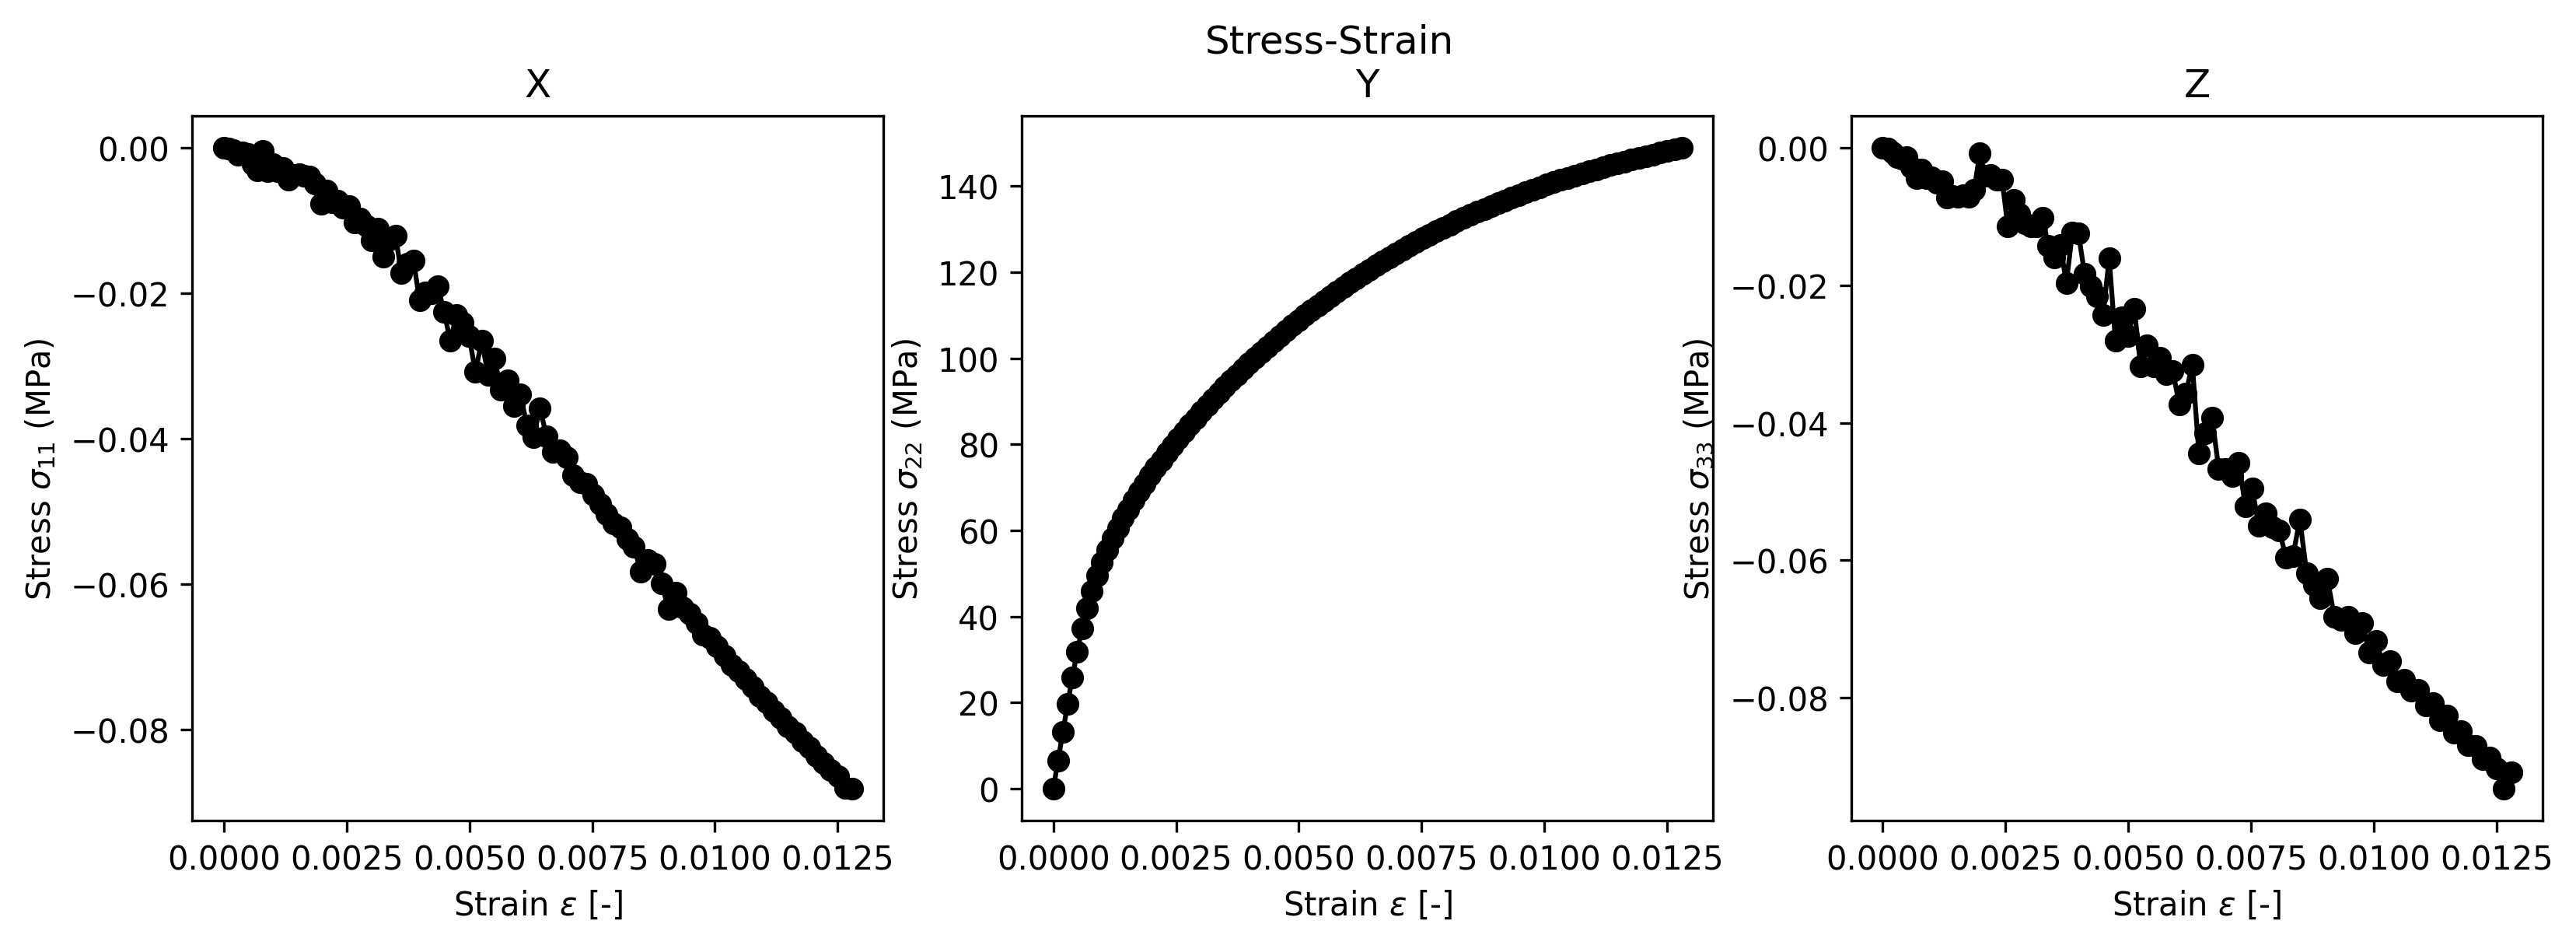

In [41]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

axes = ["X", "Y", "Z"]

fig, axs = plt.subplots(1,3, figsize=(13, 4), dpi=300, facecolor='w')
fig.suptitle('Stress-Strain')

for i, axis in enumerate(axes): # loop over axes directions
    stress = ve_response["volume_data"]["sigma"]["data"][:, i, i]
    strain = ve_response["volume_data"]["epsilon_V^0(F)_vM"]["data"]
    
    axs[i].plot(strain, stress/1e6, linestyle='solid', marker='o', color="k")
    axs[i].title.set_text(f"{axis}")
    axs[i].set_facecolor("white")
    axs[i].set_xlabel(f"Strain $\epsilon$ [-]")
    axs[i].set_ylabel(f"Stress $\sigma_{{{str(i+1)}{str(i+1)}}}$ (MPa)") #stress is plotted on scale of MPa (/1e6).

# Note: plots axes are labelled, but plots are not titled.
# this is so that the user may title their plot, and so that
# it may be easily combined with another plot.

---
## Plotting True-Stress Against Lattice Strain of a matflow-DAMASK Simulation
The following takes a matflow workflow's `workflow.hdf5` file and plots true stress against lattice strain for each user-defined crystallographic plane.

Import crystallographic parameters from crystallographic_params.yaml file.
Get unit vector describing the measurement direction given axis as string with function that turns "X" into "[1, 0, 0]"
Check for diffraction using tolerance of 5degrees of satisfying Bragg condition.
Read off lattice strains for these material points and add to bin for lattice plane label.
Plot these lattice strains against true stress of the volume element.

Warning: This can take between up to 2hrs to compute for a $128^3$ volume element with 100 strain increments.

In [4]:
from utils import import_diff_params

phases = import_diff_params("Ti_alpha", "Ti_beta")

In [5]:

import matplotlib.pyplot as plt
from lattice_strain import lattice_strain

# define ve_response in workflow for stress and strain data...
ve_response = workflow.tasks.simulate_volume_element_loading.elements[0].outputs.volume_element_response
true_stress = ve_response['volume_data']['sigma']['data'][:,1, 1]/1e6 # this is for Y axis. X would be [0, 0]

axes = ["X", "Y", "Z"] # specify axis direction

latticestrain={}
plane_intensity={}
for axis in axes: # plot subsequent plots for every axis direction

    # calculate lattice strains and count material points with that lattice strain
    latticestrain[axis], plane_intensity[axis] = lattice_strain(workflow, phases, axis=axis, tol=10)

Processing phase Ti_alpha...
Processing plane {10-10} in direction [1. 0. 0.],[0,0]...
Processing plane {0002} in direction [1. 0. 0.],[0,0]...
Processing plane {10-11} in direction [1. 0. 0.],[0,0]...
Processing plane {11-20} in direction [1. 0. 0.],[0,0]...
Processing phase Ti_beta...
Processing plane {110} in direction [1. 0. 0.],[0,0]...
Processing plane {200} in direction [1. 0. 0.],[0,0]...
Processing phase Ti_alpha...
Processing plane {10-10} in direction [0. 1. 0.],[1,1]...
Processing plane {0002} in direction [0. 1. 0.],[1,1]...
Processing plane {10-11} in direction [0. 1. 0.],[1,1]...
Processing plane {11-20} in direction [0. 1. 0.],[1,1]...
Processing phase Ti_beta...
Processing plane {110} in direction [0. 1. 0.],[1,1]...
Processing plane {200} in direction [0. 1. 0.],[1,1]...
Processing phase Ti_alpha...
Processing plane {10-10} in direction [0. 0. 1.],[2,2]...
Processing plane {0002} in direction [0. 0. 1.],[2,2]...
Processing plane {10-11} in direction [0. 0. 1.],[2,2]..

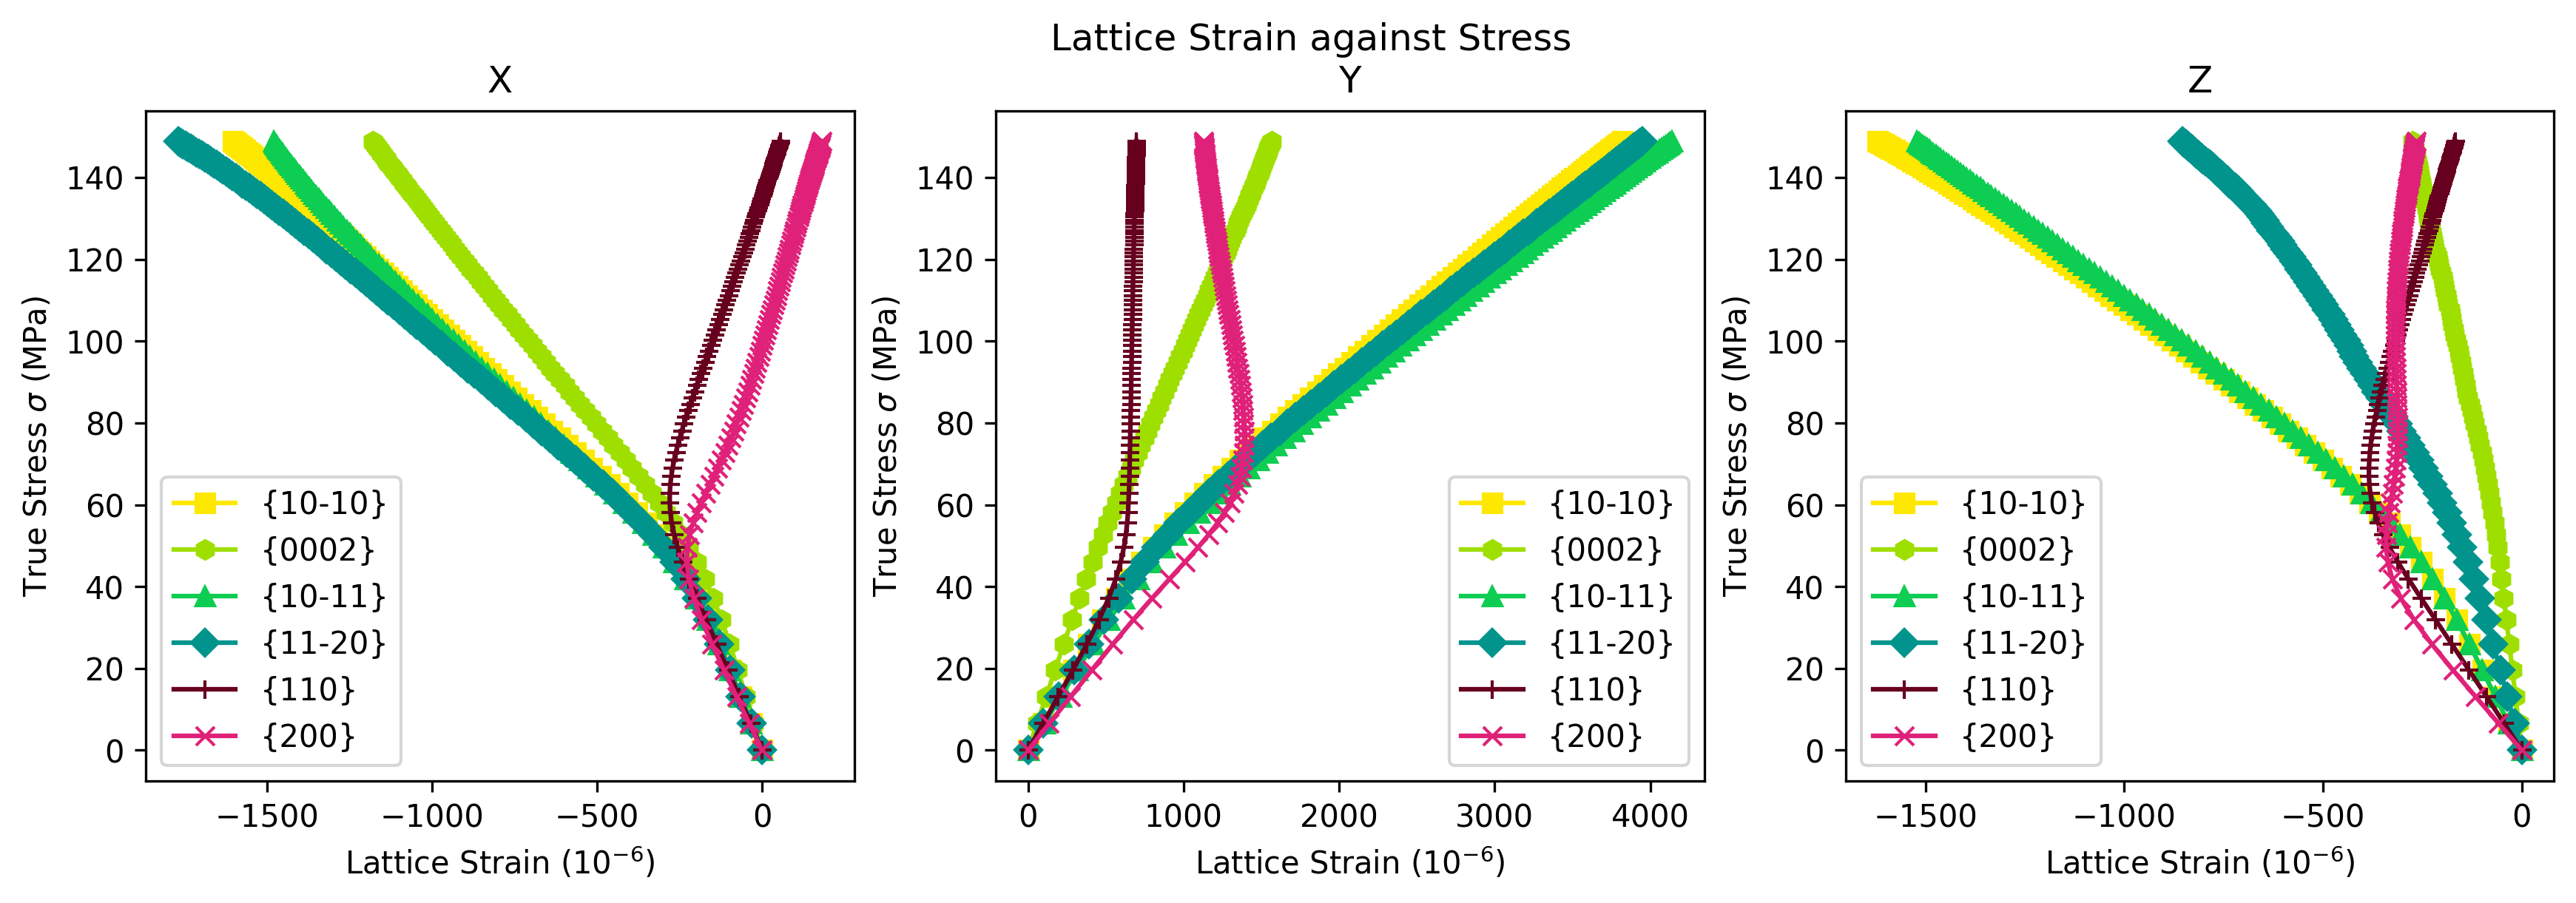

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from plotting import plot_latticestrain

fig, axs = plt.subplots(1,3, figsize=(14, 4), dpi=300) # one row, three coloumns
fig.suptitle('Lattice Strain against Stress')
for i, axis in enumerate(axes):
    plot_latticestrain(axs[i], true_stress, latticestrain, axis, incs="*", xlim=None, ylim=None)
    
plt.savefig(workflow_dir+"Latticestrain_stress", dpi='figure')


NameError: name 'tensor_comp' is not defined

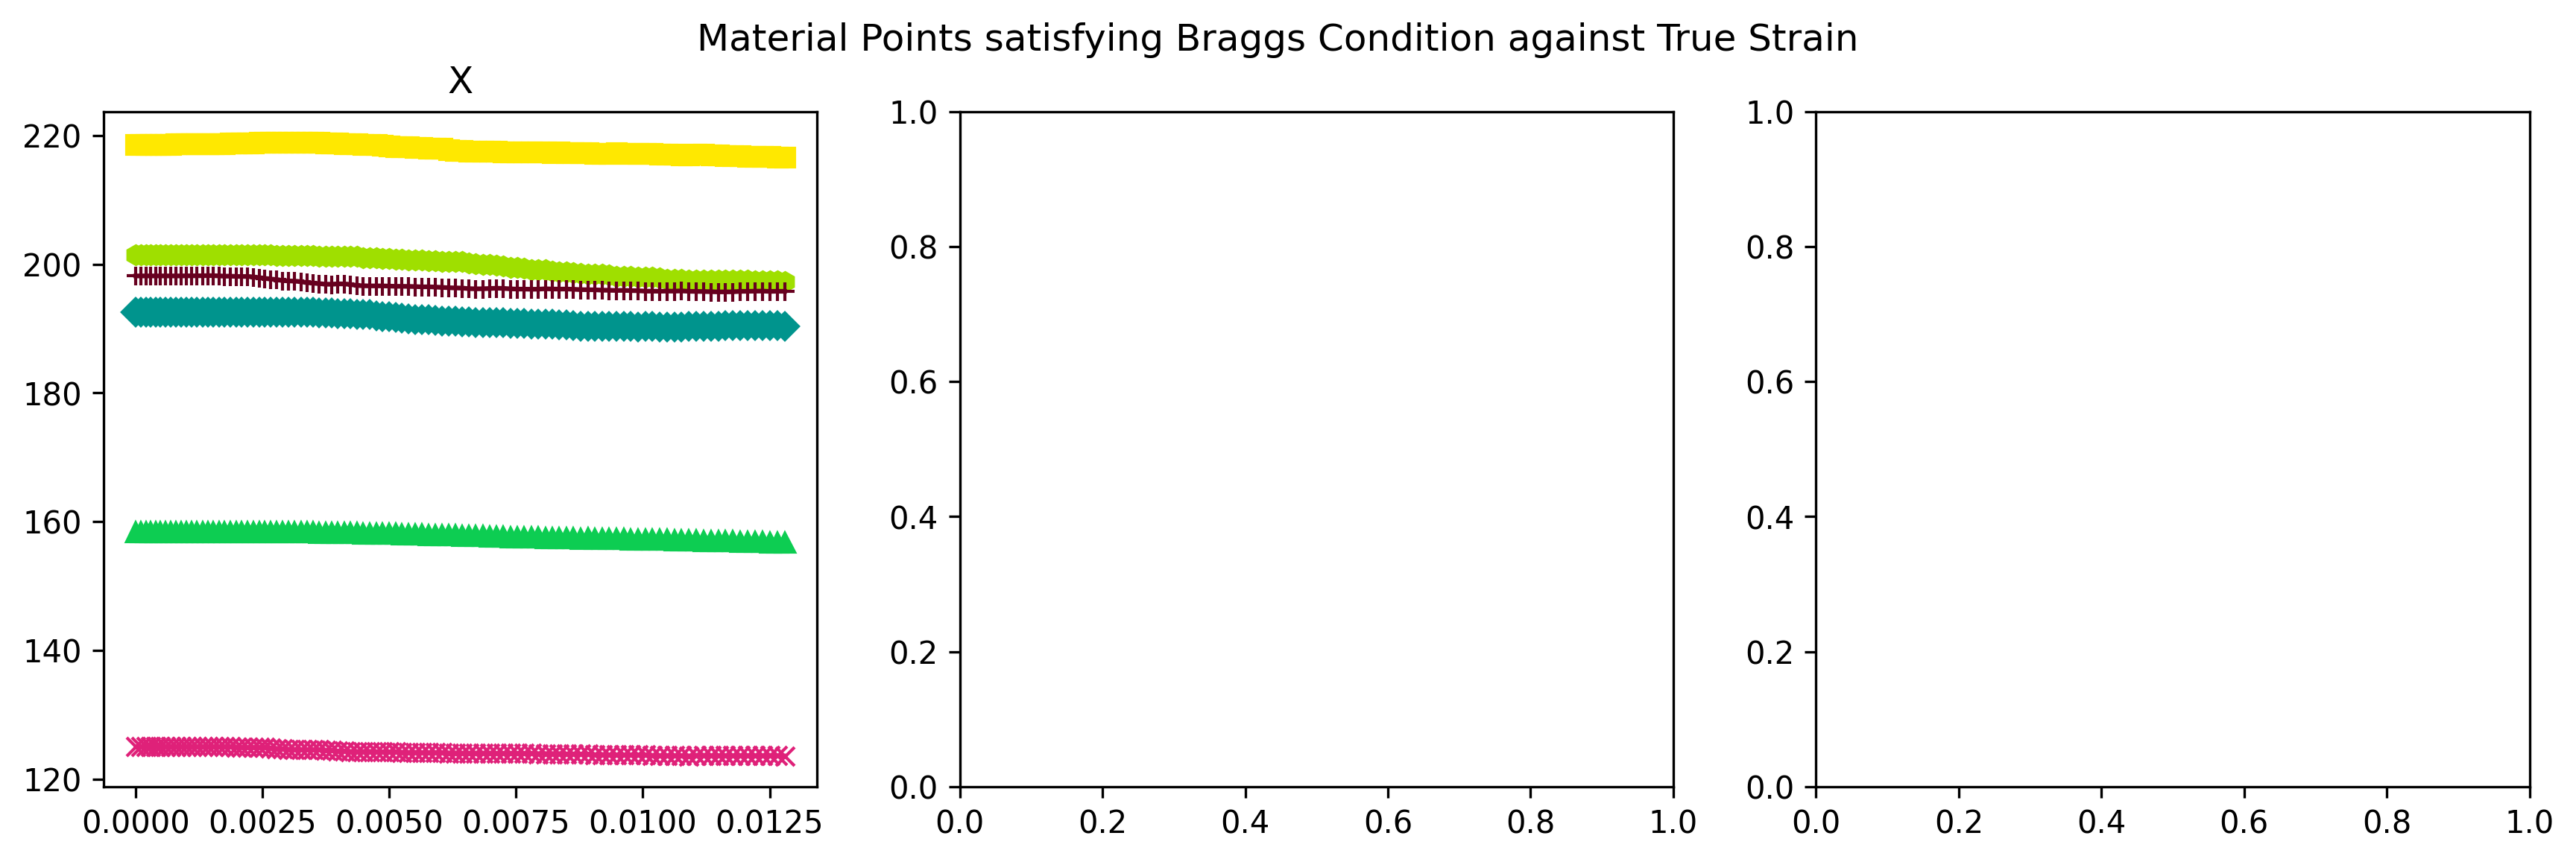

In [9]:
%matplotlib inline
from plotting import plot_true_strain_vs_peakint

ve_response = workflow.tasks.simulate_volume_element_loading.elements[0].outputs.volume_element_response
true_strain = ve_response['volume_data']['epsilon_V^0(F)_vM']['data']

fig, axs = plt.subplots(1,3, figsize=(14, 4), dpi=300) # one row, three coloumns
fig.suptitle(f"Material Points satisfying Braggs Condition against True Strain")
for i, axis in enumerate(axes):
    plot_true_strain_vs_peakint(axs[i], plane_intensity, true_strain, axis, xlim=None, ylim=None)
    
plt.savefig(workflow_dir+"Intensity_truestrain", dpi='figure')


phase: Ti_beta Direction: X
	plane: {110}	lattice strain 
	plane: {200}	lattice strain 
phase: Ti_beta Direction: Y
	plane: {110}	lattice strain 
	plane: {200}	lattice strain 
phase: Ti_beta Direction: Z
	plane: {110}	lattice strain 
	plane: {200}	lattice strain 


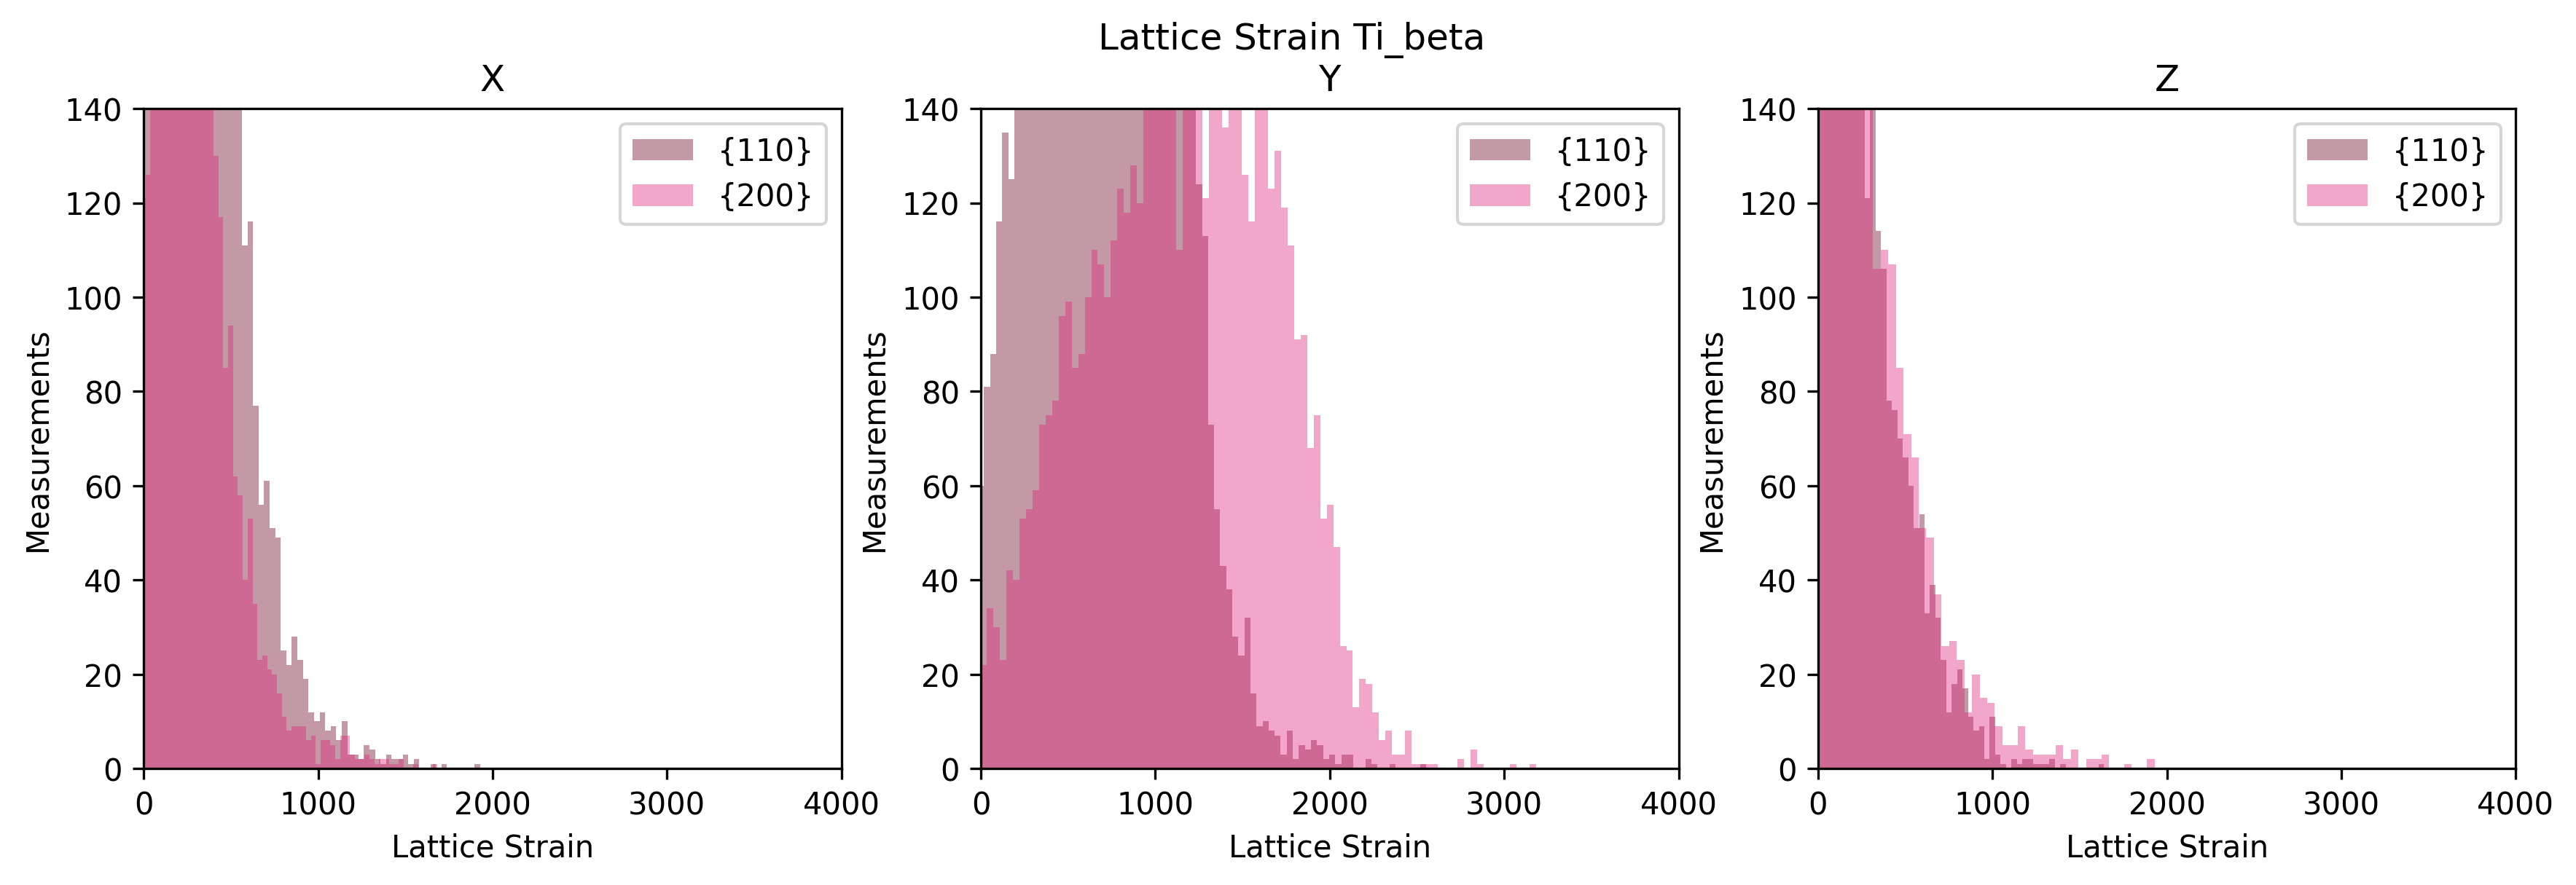

In [10]:
%matplotlib inline
from plotting import plot_lattice_strain_dist_inc

fig, axs = plt.subplots(1,3, figsize=(14, 4), dpi=300) # one row, three coloumns
for i, axis in enumerate(axes):
    plot_lattice_strain_dist_inc(axs[i], latticestrain, axis,
                                 phase="Ti_beta", inc=100, bins=100,
                                 xmin=0, xlim=4000,
                                 ymin=0, ylim=140)
fig.suptitle(f"Lattice Strain Ti_beta")

plt.savefig(workflow_dir+"Latticestrain_dist_beta_inc100", dpi='figure')


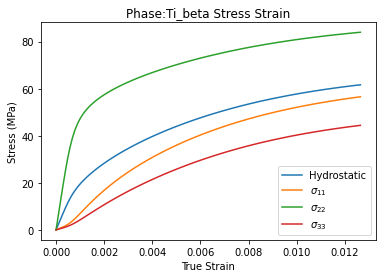

In [11]:
import numpy as np
import matplotlib.pyplot as plt
## plot hydrostatic strain with engineering strain

phase="Ti_beta"
total_incs=range(0,100)

true_strain = []
sigma_X = []
sigma_Y = []
sigma_Z = []
triaxial_stress = []

# calculate hydrostatic stress from tensor components
for inc in range(0, 100):
    true_strain.append(ve_response["volume_data"]['epsilon_V^0(F)_vM']['data'][inc])
    sigma_X.append( ve_response["phase_data"][phase+'_sigma']['data'][inc,:,0,0].mean(axis=0)/1e6 )
    sigma_Y.append( ve_response["phase_data"][phase+'_sigma']['data'][inc,:,1,1].mean(axis=0)/1e6 )
    sigma_Z.append( ve_response["phase_data"][phase+'_sigma']['data'][inc,:,2,2].mean(axis=0)/1e6 )
    triaxial_stress.append( (sigma_X[inc] + sigma_Y[inc] + sigma_Z[inc])/3 )
plt.plot(true_strain, triaxial_stress, label="Hydrostatic")
plt.plot(true_strain, sigma_X, label="$\sigma_{11}$")
plt.plot(true_strain, sigma_Y, label="$\sigma_{22}$")
plt.plot(true_strain, sigma_Z, label="$\sigma_{33}$")
plt.title(f"Phase:{phase} Stress Strain")
plt.xlabel("True Strain")
plt.ylabel("Stress (MPa)")
plt.legend()